#Install:

In [ ]:
!apt-get install python3-pypdf2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-pypdf2 is already the newest version (1.26.0-2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
!pip install -U -q PyDrive

In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install cloudstorage

In [ ]:
!pip install webapp2

In [ ]:
!pip install fsspec

In [ ]:
!pip install gcsfs

#Get auth to bucket:

In [ ]:
!gcloud auth login
!gcloud auth application-default login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=S9mUjJk7byhrgHisRPAEaFWg3wfswx&prompt=consent&access_type=offline&code_challenge=DmtbqiwJrXBJDNOgNS5oKRpQ5W9nu0qE9-KBQubEN3U&code_challenge_method=S256

Enter verification code: 4/1AX4XfWjVZ646w3okOnmlwwbVbFG68FrTWjrXi9-ep0JJPmBtddLr5rQkX_g

You are now logged in as [yixunz@berkeley.edu].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?re

# Import:

In [ ]:
import pandas as pd
import zipfile
from google.colab import drive
import re
import time
import glob
import numpy as np
import datetime as dt
from calendar import monthrange
import nltk
import PyPDF2
from sentence_transformers import SentenceTransformer
import cloudstorage as gcs
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
column_names=['ReportType', 'CIK', 'Conformed Name', 'Former Conformer names', 'kq_Year', 'kq_month', 'Filer', 'Reports', 'Exhibits']

In [ ]:
start_time = "2013-01-01"
end_time = "2019-01-01"
sen_res_file = '/content/drive/MyDrive/final_sen_res_10K_201318.txt'

# Read a table with sustainability score and transcripts:

In [ ]:
univ_with_scores_transcript = pd.read_csv("/content/drive/MyDrive/univ_with_map_and_scores_and_transcripts_df.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (51,52) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
univ_with_scores_transcript

,Unnamed: 0,Unnamed: 0.1,date,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker_univ,gvkey,iid,start,ending,ret_month_one,ret_month_two,ret_month_three,three_month_return,ticker1,ticker2,ticker3,ticker,CapitalIQ_ID,Company,total_esg_score,total_esg_score_lead_1,total_esg_score_lead_3,total_esg_score_month_change_pure,total_esg_score_month_change_pct,total_esg_score_quarter_change_pure,total_esg_score_quarter_change_pct,governance_score_lead_1,governance_score_lead_3,governance_score_month_change_pure,governance_score_month_change_pct,governance_score_quarter_change_pure,governance_score_quarter_change_pct,social_score_lead_1,social_score_lead_3,social_score_month_change_pure,social_score_month_change_pct,social_score_quarter_change_pure,social_score_quarter_change_pct,environment_score_lead_1,environment_score_lead_3,environment_score_month_change_pure,environment_score_month_change_pct,environment_score_quarter_change_pure,environment_score_quarter_change_pct,CapitalIQ_ID_join2,Company_join2,CapitalIQ_ID_join3,Company_join3,quarter,year,month,symbol,time,quarter_join1,year_join1,speech,symbol_join2,time_join2,quarter_join2,year_join2,symbol_join3,time_join3,quarter_join3,year_join3
0,0,0,2009-12-31,87432.0,AGILENT TECHNOLOGIES INC,00846U10,11.0,1.0,3826.0,A,126554,01,2000-06-05,2020-12-31,0.074343,-0.097844,0.122369,0.087828,A,NaN,NaN,NaN,IQ154924,Agilent Technologies Inc.,69.00,69.00,69.00,0.00,0.000000,0.00,0.000000,70.00,70.00,0.00,0.000000,0.00,0.000000,72.00,72.00,0.00,0.000000,0.00,0.000000,65.0,65.0,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,4,2009,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2009-12-31,24643.0,ALCOA INC,01381710,11.0,1.0,3355.0,AA,1356,01,1957-03-01,2020-12-31,0.287540,-0.210298,0.047133,0.064696,AA,ARNC,HWM,HWM,IQ249603,Alcoa Inc.,67.00,69.00,69.00,2.00,0.029851,2.00,0.029851,76.00,76.00,8.00,0.117647,8.00,0.117647,68.00,68.00,0.00,0.000000,0.00,0.000000,64.0,64.0,-1.0,-0.015385,-1.0,-0.015385,NaN,NaN,NaN,NaN,4,2009,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2009-12-31,14593.0,APPLE INC,03783310,11.0,3.0,3571.0,AAPL,1690,01,1982-11-18,2020-12-31,0.054134,-0.088591,0.065380,0.023561,AAPL,NaN,NaN,NaN,IQ24937,Apple Inc.,56.00,56.00,56.00,0.00,0.000000,0.00,0.000000,63.00,63.00,0.00,0.000000,0.00,0.000000,38.00,38.00,0.00,0.000000,0.00,0.000000,68.0,68.0,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,4,2009,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2009-12-31,81540.0,AMERISOURCEBERGEN CORP,03073E10,11.0,1.0,8099.0,ABC,31673,01,2001-08-30,2020-12-31,0.055893,0.045646,0.031548,0.138923,ABC,NaN,NaN,NaN,IQ24809,AmerisourceBergen Corporation,50.00,50.00,50.00,0.00,0.000000,0.00,0.000000,78.00,78.00,0.00,0.000000,0.00,0.000000,45.00,45.00,1.00,0.022727,1.00,0.022727,36.0,36.0,-2.0,-0.052632,-2.0,-0.052632,NaN,NaN,NaN,NaN,4,2009,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2009-12-31,20482.0,ABBOTT LABORATORIES,00282410,11.0,1.0,5047.0,ABT,1078,01,1957-03-01,2020-12-31,-0.009176,-0.012039,0.025312,0.003673,ABT,NaN,NaN,NaN,IQ247483,Abbott Laboratories,63.00,66.00,66.00,3.00,0.047619,3.00,0.047619,66.00,66.00,4.00,0.064516,4.00,0.064516,63.00,63.00,4.00,0.067797,4.00,0.067797,70.0,70.0,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,4,2009,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66625,66625,66625,2020-12-31,85348.0,YUM BRANDS INC,98849810,11.0,1.0,5812.0,YUM,65417,01,1997-10-07,2020-12-31,0.026087,NaN,NaN,NaN,YUM,NaN,NaN,NaN,IQ365997,"Yum! Brands, Inc.",53.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2020,12,YUM,2018-12-08 00:52:07,-1.0,2018.0,"All right. Thank you, everyone, for joining us...",NaN,

#CIK_TiCKER:

In [ ]:
cik_ticker = pd.read_csv('gs://content/drive/MyDrive/MIDS/just_cik_ticker.txt', delimiter='\t')

In [ ]:
cik_ticker

,Ticker,CIK
0,aapl,320193
1,msft,789019
2,amzn,1018724
3,goog,1652044
4,tcehy,1293451
...,...,...
12852,aac-wt,1829432
12853,aaic-pb,1209028
12854,aaic-pc,1209028
12855,aaqc-un,1838883


In [ ]:
cik_ticker['Ticker'] = cik_ticker['Ticker'].str.upper()
cik_ticker['CIK'] = cik_ticker['CIK'].astype(str)
cik_ticker

,Ticker,CIK
0,AAPL,320193
1,MSFT,789019
2,AMZN,1018724
3,GOOG,1652044
4,TCEHY,1293451
...,...,...
12852,AAC-WT,1829432
12853,AAIC-PB,1209028
12854,AAIC-PC,1209028
12855,AAQC-UN,1838883


Each ticker has 1 CIK, and each CIK can have multiple tickers:

In [ ]:
CIK_counts_per_ticker = cik_ticker.groupby('Ticker').nunique()
CIK_counts_per_ticker.sort_values('CIK', ascending=False).reset_index()

,Ticker,CIK
0,A,1
1,OLO,1
2,OLB,1
3,OLCLF,1
4,OLCLY,1
...,...,...
12850,FHN-PD,1
12851,FHN-PE,1
12852,FHN-PF,1
12853,FHNNP,1


In [ ]:
ticker_counts_per_CIK = cik_ticker.groupby('CIK').nunique()
ticker_counts_per_CIK.sort_values('Ticker', ascending=False).reset_index()

,CIK,Ticker
0,312070,75
1,1114446,58
2,1053092,25
3,1026214,25
4,831001,21
...,...,...
9460,1509745,1
9461,1509646,1
9462,1509589,1
9463,1509470,1


The unique number of CIK:

In [ ]:
len(cik_ticker['CIK'].unique())

9465

The unique number of Ticker:

In [ ]:
len(cik_ticker['Ticker'].unique())

12856

In [ ]:
cik_ticker[cik_ticker.Ticker.isin(['MSFT'])]

,Ticker,CIK
1,MSFT,789019


In [ ]:
cik_ticker[cik_ticker.CIK.isin(['789019'])]

,Ticker,CIK
1,MSFT,789019


In [ ]:
cik_ticker[cik_ticker.CIK.isin(['1711269'])]

,Ticker,CIK
885,EVRG,1711269


#Merge sustainability score and cik tables:

Add CIK to result table:

In [ ]:
final_res_table = pd.merge(cik_ticker, univ_with_scores_transcript, how="right", left_on=["Ticker"], right_on=["ticker_univ"]).drop_duplicates()

Find how many 'Ticker' is not the same as 'ticker_univ':

In [ ]:
np.where(final_res_table['Ticker'] != final_res_table['ticker_univ'])[0].size

10231

In [ ]:
final_res_table = final_res_table.loc[:, 'CIK':'year_join3']

In [ ]:
len(final_res_table[final_res_table.CIK.isin(["789019"])])

133

In [ ]:
len(final_res_table[final_res_table.CIK.isin(["789019"])][final_res_table.date.str.startswith('2016')])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


12

Get all the unique CIK from result table:

In [ ]:
selected_cik = final_res_table['CIK']
selected_cik = selected_cik.unique()
len(selected_cik)

591

In [ ]:
'789019' in selected_cik

True

In [ ]:
final_res_table.columns

Index(['CIK', 'Unnamed: 0', 'Unnamed: 0.1', 'date', 'permno', 'comnam',
       'ncusip', 'shrcd', 'exchcd', 'hsiccd', 'ticker_univ', 'gvkey', 'iid',
       'start', 'ending', 'ret_month_one', 'ret_month_two', 'ret_month_three',
       'three_month_return', 'ticker1', 'ticker2', 'ticker3', 'ticker',
       'CapitalIQ_ID', 'Company', 'total_esg_score', 'total_esg_score_lead_1',
       'total_esg_score_lead_3', 'total_esg_score_month_change_pure',
       'total_esg_score_month_change_pct',
       'total_esg_score_quarter_change_pure',
       'total_esg_score_quarter_change_pct', 'governance_score_lead_1',
       'governance_score_lead_3', 'governance_score_month_change_pure',
       'governance_score_month_change_pct',
       'governance_score_quarter_change_pure',
       'governance_score_quarter_change_pct', 'social_score_lead_1',
       'social_score_lead_3', 'social_score_month_change_pure',
       'social_score_month_change_pct', 'social_score_quarter_change_pure',
       'social_sco

In [ ]:
reports_res_table = final_res_table[['CIK',
                                   'date',
                                  'ticker_univ',
                                  'total_esg_score',
                                  'total_esg_score_quarter_change_pure',
                                  'total_esg_score_quarter_change_pct',
                                  'governance_score_quarter_change_pure',
                                  'governance_score_quarter_change_pct',
                                  'social_score_quarter_change_pure',
                                  'social_score_quarter_change_pct',
                                  'environment_score_quarter_change_pure',
                                  'environment_score_quarter_change_pct',
                                  'quarter',
                                  'year',
                                  'month']]
len(reports_res_table.drop_duplicates())

66497

In [ ]:
reports_res_table = reports_res_table[reports_res_table.year.isin([2013, 2014, 2015, 2016, 2017, 2018])].drop_duplicates()

In [ ]:
reports_res_table = reports_res_table[reports_res_table.total_esg_score_quarter_change_pure.notnull()]

#Create 10K and 10Q report table:

In [ ]:
def create_10_K_Q_df(zf, start_i, end_i):
  kq_df = pd.DataFrame(columns=column_names)
  for f in zf.namelist()[start_i:end_i]:
    if '.txt' not in f:
      continue
    
    # Read the whole file contents
    content = open(zf.extract(f)).read()
    
    # Split based on </Header>
    report_header, report_contents = re.split(r'\<\/Header\>', content)
    
    # Detect report type 10Q or 10K
    reportType = "10Q"
    raw_file_name = re.search(r'(?<=<FileName>).*\<\/FileName\>', report_header)
    raw_file_name = raw_file_name[0].replace('-', '')
    
    # Set report type
    filer_date, file_name = raw_file_name.split('_', 1)
    if file_name.startswith('10K'):
      reportType = "10K"
    
    # Set filer
    SEC_Header_first_part, filer = re.split(r'FILER:', report_header, 1)
    cik = re.search(r'(?<=CENTRAL INDEX KEY:).*\S', filer)[0]
    cik = cik.replace('\t', '').replace('\n', '').strip("0")
    if cik not in selected_cik:
      continue
    report_time = re.search(r'(?<=CONFORMED PERIOD OF REPORT:\t)[0-9]{8}', SEC_Header_first_part)[0]
    
    # Report date in the file
    year = (int)(report_time[0:4])
    month = (int)(report_time[4:6])
    if month in [12, 1, 2]:
      if month != 12:
        year -= 1
      month = 12
    elif month in [3, 4, 5]:
      month = 3
    elif month in [6, 7, 8]:
      month = 6
    else:
      month = 9

    # Former company names
    former_names = re.findall(r'(?<=FORMER CONFORMED NAME:).*\s', filer)
    parsed_former_names = []
    for n in former_names:
      parsed_former_names.append(n.replace('\t', '').replace('\n', ''))
    conformed_name = re.search(r'(?<=COMPANY CONFORMED NAME:).*\s', filer)[0].replace('\n', '').replace('\t', '')
    filer = filer.replace('\t', '').replace('\n', '')
   
    # Exhibits
    reports = re.split(r'\<EX.*\>', report_contents, 1)
    if len(reports) == 2:
      exhibits = reports[1].replace('\n', '').replace('\t', '')
    reports = reports[0].replace('\n', '').replace('\t', '')

    # Append each row to the data frame
    parsed_row = pd.Series([reportType, cik, conformed_name, ','.join([str(name) for name in parsed_former_names]), year, month, filer, reports, exhibits], index=kq_df.columns)
    kq_df = kq_df.append(parsed_row, ignore_index=True)

  return kq_df

In [ ]:
def merge_kq_ticker(left_df, output_path):
  res_kq_pd = pd.merge(left=left_df, right=cik_ticker, left_on="CIK", right_on="CIK")
  res_kq_pd.to_csv(output_path)

In [ ]:
def get_kq_res(zf_files, zf_name):
  kq_res = create_10_K_Q_df(zf_files, 0, len(zf_files.namelist()))
  kq_res_file_name = 'just_10kq_without_score_' + zf_name + '.txt'
  merge_kq_ticker(kq_res, kq_res_file_name)

In [ ]:
kq_201318 = pd.read_csv("gs://esgbert_resourses/raw_data/just_10kq_without_score_201318.txt")

/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [ ]:
kq_201318

,ReportType,CIK,kq_Year,kq_month,Reports,Ticker
0,10Q,23217,2015,9,0001628280-16-010116.txt : 2016010610-Q 1 cag...,CAG
1,10Q,23217,2015,12,0001628280-16-014070.txt : 2016040710-Q 1 cag...,CAG
2,10K,23217,2016,3,0001628280-16-017613.txt : 2016071510-K 1 cag...,CAG
3,10Q,23217,2016,6,0001628280-16-019920.txt : 2016100410-Q 1 cag...,CAG
4,10Q,23217,2016,9,0001628280-17-000036.txt : 2017010410-Q 1 cag...,CAG
...,...,...,...,...,...,...
10650,10Q,1730168,2018,6,0001730168-18-000039.txt : 2018091310-Q 1 avg...,AVGO
10652,10K,1730168,2018,9,0001730168-18-000084.txt : 2018122110-K 1 avg...,AVGO
10654,10Q,1711269,2018,6,0001711269-18-000012.txt : 2018080810-Q 1 evr...,EVRG
10657,10Q,1711269,2018,9,0001711269-18-000022.txt : 2018110710-Q 1 evr...,EVRG


In [ ]:
kq_201318[['ReportType', 'CIK', 'kq_Year', 'kq_month', 'Reports']].groupby(['ReportType', 'CIK', 'kq_Year', 'kq_month']).agg(['count'])

Reports
                                      count
ReportType CIK     kq_Year kq_month        
10K        2488    2015    12             1
                   2016    12             1
                   2017    12             1
           2969    2016    9              1
                   2017    9              1
...                                     ...
10Q        1707925 2018    9              1
           1711269 2018    6              1
                           9              1
           1730168 2018    3              1
                           6              1

[5875 rows x 1 columns]

In [ ]:
test_20162018_10Q_MS = kq_201618[kq_201618.ReportType.isin(['10Q'])][kq_201618.CIK == 789019]
assert len(test_20162018_10Q_MS[test_20162018_10Q_MS.duplicated(['CIK', 'kq_Year', 'kq_month'])]) == 0, "10Q Report for MSFT should be just one quarterly"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [ ]:
test_20132015_10Q_MS = kq_201315[kq_201315.ReportType.isin(['10Q'])][kq_201315.CIK == 789019]
assert len(test_20132015_10Q_MS[test_20132015_10Q_MS.duplicated(['CIK', 'kq_Year', 'kq_month'])]) == 0, "10Q Report for MSFT should be just one quarterly"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [ ]:
test_20162018_10Q = kq_201618[kq_201618.ReportType.isin(['10Q'])]
assert len(test_20162018_10Q[test_20162018_10Q.duplicated(['CIK', 'kq_Year', 'kq_month'])]) == 0, "10Q Report for every company should be just one quarterly"

In [ ]:
test_20132015_10Q = kq_201315[kq_201315.ReportType.isin(['10Q'])]
assert len(test_20132015_10Q_MS[test_20132015_10Q_MS.duplicated(['CIK', 'kq_Year', 'kq_month'])]) == 0, "10Q Report for every company should be just one quarterly"

Clean up temporary data

In [ ]:
!rm -rf "/content/2016" & rm -rf "/content/2017" & rm -rf "/content/2018"

In [ ]:
!rm -rf "/content/2011" & rm -rf "/content/2012" & rm -rf "/content/2013" & rm -rf "/content/2014" & rm -rf "/content/2015"

In [ ]:
frames = [kq_201315, kq_201618]
res_df = pd.concat(frames)

In [ ]:
res_df.to_csv("final_kq_reports_without_earning_calls.csv")

#Read 10K and 10Q report table without earning calls:

In [ ]:
res_df = pd.read_csv("gs://esgbert_resourses/raw_data/final_kq_reports_without_earning_calls.csv")

In [ ]:
res_df_10K = res_df[res_df.ReportType.isin(['10K'])]

# Finalize final result table:

In [ ]:
res_df_10K['CIK'] = res_df_10K['CIK'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
reports_res_table['CIK'] = reports_res_table['CIK'].astype(str)

In [ ]:
new_df = pd.merge(reports_res_table, res_df_10K,  how='left', left_on=['CIK','year', 'month'], right_on = ['CIK','kq_Year', 'kq_month'])

In [ ]:
new_df = new_df[new_df['ReportType'].notna()]

In [ ]:
new_df=new_df.drop_duplicates(subset=['ReportType', 'CIK', 'kq_Year', 'kq_month', 'total_esg_score'])

In [ ]:
new_df.columns

Index(['CIK', 'date', 'ticker_univ', 'total_esg_score',
       'total_esg_score_quarter_change_pure',
       'total_esg_score_quarter_change_pct',
       'governance_score_quarter_change_pure',
       'governance_score_quarter_change_pct',
       'social_score_quarter_change_pure', 'social_score_quarter_change_pct',
       'environment_score_quarter_change_pure',
       'environment_score_quarter_change_pct', 'quarter', 'year', 'month',
       'Unnamed: 0', 'ReportType', 'kq_Year', 'kq_month', 'Reports', 'Ticker'],
      dtype='object')

In [ ]:
new_df = new_df[['CIK', 'date', 'total_esg_score', 'total_esg_score_quarter_change_pure', 'total_esg_score_quarter_change_pct', 'governance_score_quarter_change_pure',
       'governance_score_quarter_change_pct', 'social_score_quarter_change_pure', 'social_score_quarter_change_pct', 'environment_score_quarter_change_pure',
       'environment_score_quarter_change_pct', 'quarter', 'year', 'month', 'ReportType', 'Reports']].drop_duplicates()

In [ ]:
new_df = new_df.drop_duplicates(subset=['ReportType', 'CIK', 'year', 'month'])

In [ ]:
new_df[['ReportType', 'CIK', 'year', 'month', 'Reports']].groupby(['ReportType', 'CIK', 'year', 'month']).agg(['count'])

Reports
                                count
ReportType CIK     year month        
10K        1000228 2015 12          1
                   2016 12          1
                   2017 12          1
           1000697 2013 12          1
                   2014 12          1
...                               ...
           98246   2013 12          1
                   2014 12          1
                   2015 12          1
                   2016 12          1
                   2017 12          1

[1824 rows x 1 columns]

In [ ]:
test_new_df_ms = new_df[new_df.ReportType.isin(['10K'])][new_df.CIK == '789019']
assert len(test_new_df_ms[test_new_df_ms.duplicated(['CIK', 'year', 'month'])]) == 0, "10Q Report for MSFT should be just one quarterly"

In [ ]:
test_new_df = new_df[new_df.ReportType.isin(['10K'])]
assert len(test_new_df[test_new_df.duplicated(['CIK', 'year', 'month'])]) == 0, "10Q Report for every company should be just one quarterly"

In [ ]:
#res_df['CIK'] = res_df.CIK.astype(str)
#final_res_table_sorted = final_res_table.copy().sort_values(by=['date', 'CIK'])
#res_df_sorted = res_df.copy().sort_values(by=['Report Date', 'CIK'])
#res_df_sorted.rename(columns={'Report Date': 'date'}, inplace=True)
#res_df_sorted.date = pd.to_datetime(res_df_sorted.date)
#final_res_table_sorted.date = pd.to_datetime(final_res_table_sorted.date)
#merged_table = pd.merge_asof(final_res_table_sorted, res_df_sorted, on='date', by='CIK', direction='nearest')
#merged_table

Number of 10Q report whose total_esg_score is not null: 5980

In [ ]:
new_df_10Q = new_df[new_df['ReportType'] == '10Q']
new_df_10Q = new_df_10Q[new_df_10Q.total_esg_score.notna()]
len(new_df_10Q)

5980

In [ ]:
#new_df_10Q.to_csv("final_10Q_reports_with_score_without_sorted_sen.csv")

In [ ]:
#new_df_10K.to_csv("final_10K_reports_with_score_without_sorted_sen.csv")

In [ ]:
#!gsutil cp "final_10Q_reports_with_score_without_sorted_sen.csv" gs://esgbert_resourses/raw_data/

Copying file://final_10K_reports_with_score_without_sorted_sen.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/666.5 MiB.                                    


Number of 10K report whose total_esg_score_quarter_change_pct is not null: 1824

In [ ]:
new_df_10K = new_df[new_df['ReportType'] == '10K']
new_df_10K = new_df_10K[new_df_10K.total_esg_score.notna()]
len(new_df_10K)

1824

In [ ]:
#new_df_10K.to_csv("final_10K_reports_with_score_without_sorted_sen.csv")

In [ ]:
#!gsutil cp "final_10K_reports_with_score_without_sorted_sen.csv" gs://esgbert_resourses/raw_data/

Copying file://final_10K_reports_with_score_without_sorted_sen.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][666.5 MiB/666.5 MiB]                                                
Operation completed over 1 objects/666.5 MiB.                                    


#Test:

In [ ]:
#read_10q_df = pd.read_csv("gs://esgbert_resourses/raw_data/final_10Q_reports_with_score_without_sorted_sen.csv")
read_10k_df = pd.read_csv("gs://esgbert_resourses/raw_data/final_10K_reports_with_score_without_sorted_sen.csv")

Count of 10k and 10q reports per quarter:

In [ ]:
read_10k_df[['ReportType', 'CIK', 'year', 'month', 'Reports']].groupby(['ReportType', 'CIK', 'year', 'month']).agg(['count'])

Reports
                                count
ReportType CIK     year month        
10K        2488    2017 12          1
           2969    2013 9           1
                   2014 9           1
                   2015 9           1
                   2016 9           1
...                               ...
           1652044 2016 12          1
                   2017 12          1
           1659166 2017 12          1
           1681459 2017 12          1
           1688568 2018 3           1

[1824 rows x 1 columns]

In [ ]:
read_10q_df[['ReportType', 'CIK', 'year', 'month', 'Reports']].groupby(['ReportType', 'CIK', 'year', 'month']).agg(['count'])

Reports
                                count
ReportType CIK     year month        
10Q        2488    2013 3           1
                        6           1
                   2018 3           1
                        6           1
           2969    2013 3           1
...                               ...
           1688568 2017 12          1
                   2018 6           1
                        9           1
           1730168 2018 3           1
                        6           1

[5980 rows x 1 columns]

In [ ]:
ms_10k_df = read_10k_df[read_10k_df['CIK'].isin(['789019'])]
ms_10k_df[['ReportType', 'CIK', 'year', 'month', 'Reports']].groupby(['ReportType', 'CIK', 'year', 'month']).agg(['count'])

Reports
                               count
ReportType CIK    year month        
10K        789019 2013 6           1
                  2014 6           1
                  2015 6           1
                  2016 6           1
                  2017 6           1
                  2018 6           1

In [ ]:
reports_res_table = reports_res_table[reports_res_table['month'].isin([3, 6, 9, 12])]

In [ ]:
sorted_reports_res_table = reports_res_table[reports_res_table['CIK'] != 'nan'].sort_values(by=['CIK', 'year', 'month'])

In [ ]:
sorted_reports_res_table = sorted_reports_res_table.drop_duplicates(subset=['CIK', 'year', 'month'], keep='last')

In [ ]:
end_idx_res_table = len(sorted_reports_res_table.index)

governance_score_quarter_change_pure_10k = [0]
social_score_quarter_change_pure_10k = [0]
environment_score_quarter_change_pure_10k = [0]

for i in range(1, end_idx_res_table, 1):
  if sorted_reports_res_table.iloc[i]['CIK'] == sorted_reports_res_table.iloc[i-1]['CIK']:
    governance_score_quarter_change_pure_10k.append(sorted_reports_res_table.iloc[i]['governance_score_quarter_change_pure'] + governance_score_quarter_change_pure_10k[i-1])
    social_score_quarter_change_pure_10k.append(sorted_reports_res_table.iloc[i]['social_score_quarter_change_pure'] + social_score_quarter_change_pure_10k[i-1])
    environment_score_quarter_change_pure_10k.append(sorted_reports_res_table.iloc[i]['environment_score_quarter_change_pure'] + environment_score_quarter_change_pure_10k[i-1])
  else:
    governance_score_quarter_change_pure_10k.append(0)
    social_score_quarter_change_pure_10k.append(0)
    environment_score_quarter_change_pure_10k.append(0)
  
sorted_reports_res_table['governance_score_accumulate_change_pure_10k'] = governance_score_quarter_change_pure_10k
sorted_reports_res_table['social_score_accumulate_change_pure_10k'] = social_score_quarter_change_pure_10k
sorted_reports_res_table['environment_score_accumulate_change_pure_10k'] = environment_score_quarter_change_pure_10k

In [ ]:
sorted_reports_res_table = sorted_reports_res_table[['CIK', 'date', 'total_esg_score',
       'total_esg_score_quarter_change_pure',
       'total_esg_score_quarter_change_pct',
       'quarter', 'year', 'month',
       'governance_score_accumulate_change_pure_10k',
       'social_score_accumulate_change_pure_10k',
       'environment_score_accumulate_change_pure_10k']]

In [ ]:
sorted_reports_res_table=sorted_reports_res_table.drop_duplicates(['CIK', 'date', 'total_esg_score'])

In [ ]:
sorted_10k = read_10k_df.sort_values(by=['CIK', 'date'])

In [ ]:
end_idx = len(sorted_10k.index)
sorted_10k = read_10k_df.sort_values(by=['CIK', 'date'])
total_10k_esg_score = [0]
for i in range(1, end_idx, 1):
  if sorted_10k.iloc[i]['CIK'] == sorted_10k.iloc[i-1]['CIK']:
    total_10k_esg_score.append(sorted_10k.iloc[i]['total_esg_score'] - sorted_10k.iloc[i-1]['total_esg_score'])
  else:
    total_10k_esg_score.append(0)
sorted_10k['total_esg_score_change_10k'] = total_10k_esg_score

In [ ]:
sorted_10k = sorted_10k[['CIK', 'date', 'ReportType', 'total_esg_score', 'Reports', 'total_esg_score_change_10k']]

In [ ]:
sorted_10k[['CIK', 'date', 'total_esg_score_change_10k']].sort_values(by=['CIK', 'date'])

,CIK,date,total_esg_score_change_10k
715,2488,2017-12-29,0.00
751,2969,2013-09-30,0.00
752,2969,2014-09-30,4.00
753,2969,2015-09-30,-2.00
754,2969,2016-09-30,-1.36
...,...,...,...
647,1652044,2016-12-30,-0.17
648,1652044,2017-12-29,0.54
649,1659166,2017-12-29,0.00
656,1681459,2017-12-29,0.00


In [ ]:
sorted_10k[['CIK', 'date', 'total_esg_score_change_10k']].groupby(['CIK', 'date']).agg(['count'])

total_esg_score_change_10k
                                        count
CIK     date                                 
2488    2017-12-29                          1
2969    2013-09-30                          1
        2014-09-30                          1
        2015-09-30                          1
        2016-09-30                          1
...                                       ...
1652044 2016-12-30                          1
        2017-12-29                          1
1659166 2017-12-29                          1
1681459 2017-12-29                          1
1688568 2018-03-29                          1

[1824 rows x 1 columns]

In [ ]:
sorted_10k['CIK'] = sorted_10k['CIK'].astype(str)
sorted_10k['date'] = sorted_10k['date'].astype(str)
sorted_reports_res_table['CIK'] = sorted_reports_res_table['CIK'].astype(str)
sorted_reports_res_table['date'] = sorted_reports_res_table['date'].astype(str)

In [ ]:
final_10k = pd.merge(sorted_10k, sorted_reports_res_table,  how='left', left_on=['CIK','date', 'total_esg_score'], right_on = ['CIK','date', 'total_esg_score'])

In [ ]:
final_10k_end_idx = len(final_10k.index)
final_10k = final_10k.sort_values(by=['CIK', 'date'])

governance_score_change_pure_10k = [0]
social_score_change_pure_10k = [0]
environment_score_change_pure_10k = [0]

for i in range(1, final_10k_end_idx, 1):
  if final_10k.iloc[i]['CIK'] == final_10k.iloc[i-1]['CIK']:
    governance_score_change_pure_10k.append(final_10k.iloc[i]['governance_score_accumulate_change_pure_10k'] - final_10k.iloc[i-1]['governance_score_accumulate_change_pure_10k'])
    social_score_change_pure_10k.append(final_10k.iloc[i]['social_score_accumulate_change_pure_10k'] - final_10k.iloc[i-1]['social_score_accumulate_change_pure_10k'])
    environment_score_change_pure_10k.append(final_10k.iloc[i]['environment_score_accumulate_change_pure_10k'] - final_10k.iloc[i-1]['environment_score_accumulate_change_pure_10k'])
  else:
    governance_score_change_pure_10k.append(0)
    social_score_change_pure_10k.append(0)
    environment_score_change_pure_10k.append(0)
final_10k['governance_score_change_pure_10k'] = governance_score_change_pure_10k
final_10k['social_score_change_pure_10k'] = social_score_change_pure_10k
final_10k['environment_score_change_pure_10k'] = environment_score_change_pure_10k

In [ ]:
final_10k[final_10k['CIK'].isin(['789019'])][final_10k['date'].str.startswith('2013')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,CIK,date,ReportType,total_esg_score,Reports,total_esg_score_change_10k,total_esg_score_quarter_change_pure,total_esg_score_quarter_change_pct,quarter,year,month,governance_score_accumulate_change_pure_10k,social_score_accumulate_change_pure_10k,environment_score_accumulate_change_pure_10k,governance_score_change_pure_10k,social_score_change_pure_10k,environment_score_change_pure_10k
862,789019,2013-06-28,10K,64.0,0001193125-13-310206.txt : 2013073010-K 1 d52...,0.0,0.0,0.0,2,2013,6,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
final_10k.columns

Index(['CIK', 'date', 'ReportType', 'total_esg_score', 'Reports',
       'total_esg_score_change_10k', 'total_esg_score_quarter_change_pure',
       'total_esg_score_quarter_change_pct', 'quarter', 'year', 'month',
       'governance_score_accumulate_change_pure_10k',
       'social_score_accumulate_change_pure_10k',
       'environment_score_accumulate_change_pure_10k',
       'governance_score_change_pure_10k', 'social_score_change_pure_10k',
       'environment_score_change_pure_10k'],
      dtype='object')

In [ ]:
final_10k = final_10k[['CIK', 'date', 'ReportType', 'total_esg_score', 'Reports',
       'total_esg_score_change_10k', 'quarter', 'year', 'month',
       'governance_score_change_pure_10k', 'social_score_change_pure_10k',
       'environment_score_change_pure_10k']]

In [ ]:
read_10q_df[read_10q_df['CIK'].isin(['789019'])][read_10q_df['year'].isin([2013])]

In [ ]:
read_10q_df[read_10q_df['CIK'].isin(['789019'])][read_10q_df['year'].isin([2017])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,origin_idx,CIK,date,total_esg_score,total_esg_score_quarter_change_pure,total_esg_score_quarter_change_pct,governance_score_quarter_change_pure,governance_score_quarter_change_pct,social_score_quarter_change_pure,social_score_quarter_change_pct,environment_score_quarter_change_pure,environment_score_quarter_change_pct,quarter,year,month,ReportType,Reports,reports_ordered,reports_cosines
1328,1328,15724,789019,2017-03-31,71.49,0.25,0.003497,0.0,0.000000,0.00,0.000000,0.84,0.010316,1,2017,3,10Q,0001564590-17-007547.txt : 2017042710-Q 1 msf...,Environmental regulations or changes in the su...,0.77 0.74 0.74 0.74 0.73 0.73 0.73 0.73 0.73 0...
1329,1329,15730,789019,2017-09-29,71.17,2.99,0.042012,4.4,0.065918,1.98,0.029896,3.33,0.040476,3,2017,9,10Q,0001564590-17-020171.txt : 2017102610-Q 1 msf...,Environmental regulations or changes in the su...,0.77 0.74 0.74 0.74 0.73 0.73 0.73 0.73 0.73 0...
1330,1330,15733,789019,2017-12-29,74.16,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000000,4,2017,12,10Q,0001564590-18-001129.txt : 2018013110-Q 1 msf...,The remeasurement of deferred taxes included i...,0.77 0.76 0.74 0.74 0.74 0.74 0.73 0.73 0.73 0...


In [ ]:
final_10k[final_10k['CIK'].isin(['789019'])][final_10k['year'].isin([2017])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,CIK,date,ReportType,total_esg_score,Reports,total_esg_score_change_10k,quarter,year,month,governance_score_change_pure_10k,social_score_change_pure_10k,environment_score_change_pure_10k
866,789019,2017-06-30,10K,71.74,0001564590-17-014900.txt : 2017080210-K 1 msf...,0.71,2,2017,6,0.8,-1.02,0.84


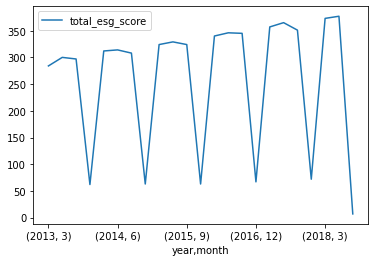

In [ ]:
counts_10q_df = read_10q_df[['total_esg_score', 'month', 'year']].groupby(by=['year', 'month']).agg('count')
counts_10q_df.plot()

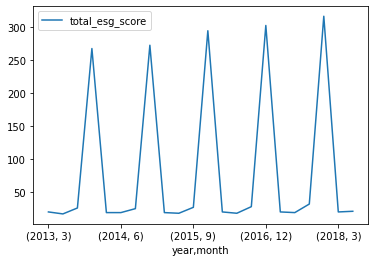

In [ ]:
counts_10k_df = final_10k[['total_esg_score', 'month', 'year']].groupby(by=['year', 'month']).agg('count')
counts_10k_df.plot()

In [ ]:
assert len(final_10k[final_10k.duplicated(['CIK', 'year', 'quarter', 'Reports'])]) == 0, "10K Report for every company should be just one quarterly"
assert len(final_10k[final_10k.duplicated(['CIK', 'date', 'Reports'])]) == 0, "10K Report for every company should be just one per date"
assert len(final_10k[final_10k.duplicated(['CIK', 'year', 'month', 'Reports'])]) == 0, "10K Report for every company should be just one per month"
assert len(final_10k[final_10k.duplicated(['CIK', 'date'])]) == 0, "10K Report for every company should be just one per date"

In [ ]:
#final_10k.to_csv('final_10K_reports_with_score_without_sorted_sen.csv')

In [ ]:
#!gsutil cp "final_10K_reports_with_score_without_sorted_sen.csv" gs://esgbert_resourses/raw_data/

Copying file://final_10K_reports_with_score_without_sorted_sen.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/666.4 MiB.                                    


#Sentence comparison:

In [ ]:
#read_10q_df = pd.read_csv("gs://esgbert_resourses/raw_data/final_10Q_reports_with_score_without_sorted_sen.csv")
read_10k_df = pd.read_csv("gs://esgbert_resourses/raw_data/final_10K_reports_with_score_without_sorted_sen.csv")

In [ ]:
len(read_10k_df)

1824

In [ ]:
read_10k_df = read_10k_df[(read_10k_df['date']>=start_time) & (read_10k_df['date']<end_time)]

In [ ]:
read_10k_df = read_10k_df.drop_duplicates()
read_10k_df = read_10k_df.drop_duplicates(subset=['CIK', 'year', 'month'], keep='last')

In [ ]:
#read_10q_df = read_10q_df[(read_10q_df['date']>=start_time) & (read_10q_df['date']<end_time)]

In [ ]:
#kq_compare_sentences_short = [
#"State of Hawaii is considering renewable energy proposals and related costs and uncertainties surrounding technologies, solar power, wind power, biofuels, environmental assessments required to meet renewable portfolio standards goals.",
#"PacifiCorp is subject to federal, state and local laws and regulations regarding air and water quality, renewable portfolio standards, emissions performance standards, climate change, coal combustion byproduct disposal, hazardous and solid waste disposal, protected species and other environmental matters that have the potential to impact PacifiCorp's current and future operations.",
#"A variety of regulatory developments, proposals or requirements and legislative initiatives are focused on restricting the emission of greenhouse gases.",
#"The Company invested in limited liability companies that sponsor renewable energy projects related to solar energy.",
#"Benefits might be realized later than expected, if ongoing investment are not successful or sustainable, we might undertake additional realignment and cost reduction efforts, which could result in future charges."                        
#]

kq_compare_sentences_3 = [
"PacifiCorp is subject to federal, state and local laws and regulations regarding air and water quality, renewable portfolio standards, emissions performance standards, climate change, coal combustion byproduct disposal, hazardous and solid waste disposal, protected species and other environmental matters that have the potential to impact PacifiCorp's current and future operations.",

"There has been an increased focus in the last several years on climate change in response to findings that emissions of carbon dioxide, methane and other greenhouse gases present an endangerment to public health and the environment. As a result, there have been a variety of regulatory developments, proposals or requirements and legislative initiatives that have been introduced in the United States (and other parts of the world) that are focused on restricting the emission of greenhouse gases.",

"Further, such benefits might be realized later than expected, and the ongoing costs of implementing these measures might be greater than anticipated. If these measures are not successful or sustainable, we might undertake additional realignment and cost reduction efforts, which could result in future charges."
]

kq_compare_sentences = [
"the potential delay by the Public Utilities Commission of the State of Hawaii (PUC) in considering (and potential disapproval of actual or proposed) renewable energy proposals and related costs; reliance by the Utilities on outside parties such as the state, independent power producers (IPPs) and developers; and uncertainties surrounding technologies, solar power, wind power, biofuels, environmental assessments required to meet renewable portfolio standards (RPS) goals and the impacts of implementation of the renewable energy proposals on future costs of electricity;",

"PacifiCorp is subject to federal, state and local laws and regulations regarding air and water quality, renewable portfolio standards, emissions performance standards, climate change, coal combustion byproduct disposal, hazardous and solid waste disposal, protected species and other environmental matters that have the potential to impact PacifiCorp's current and future operations.",

"During the   six months ended June 30, 2018  , the Company invested $  17 million   in limited liability companies that sponsor renewable energy projects related to solar energy. The Company has $  3 million   of future funding commitments for these investments as of   June 30, 2018  .",

"There has been an increased focus in the last several years on climate change in response to findings that emissions of carbon dioxide, methane and other greenhouse gases present an endangerment to public health and the environment. As a result, there have been a variety of regulatory developments, proposals or requirements and legislative initiatives that have been introduced in the United States (and other parts of the world) that are focused on restricting the emission of greenhouse gases.",

"Further, such benefits might be realized later than expected, and the ongoing costs of implementing these measures might be greater than anticipated. If these measures are not successful or sustainable, we might undertake additional realignment and cost reduction efforts, which could result in future charges."
]

In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
# clean file before writting contents
f = open(sen_res_file, 'r+')
f.truncate(0)

0

In [ ]:
read_10k_df.columns

Index(['Unnamed: 0', 'CIK', 'date', 'ReportType', 'total_esg_score', 'Reports',
       'total_esg_score_change_10k', 'quarter', 'year', 'month',
       'governance_score_change_pure_10k', 'social_score_change_pure_10k',
       'environment_score_change_pure_10k'],
      dtype='object')

In [ ]:
#read_10q_df

In [ ]:
%%time
extracted_final_table = read_10k_df.reset_index()
sbert_model=SentenceTransformer('bert-base-nli-mean-tokens')
compare_sence_encode = [sbert_model.encode([compare_sent])[0] for compare_sent in kq_compare_sentences]
compare_sence_encode = sum(compare_sence_encode) / len(kq_compare_sentences)

extracted_final_table['reports_ordered']=''
extracted_final_table['reports_cosines']=''

col_idx_orig=extracted_final_table.columns.get_loc('Reports')
col_idx_new=extracted_final_table.columns.get_loc('reports_ordered')
col_idx_cos=extracted_final_table.columns.get_loc('reports_cosines')

with open(sen_res_file, "a") as fhandle:
  fhandle.write(f'origin_idx|CIK|date|ReportType|total_esg_score|Reports|total_esg_score_change_10k|quarter|year|month|governance_score_change_pure_10k|social_score_change_pure_10k|environment_score_change_pure_10k|reports_ordered|reports_cosines\n')

for index, row in extracted_final_table.iterrows():
  print(index)

  sorted_sents_for_reports=[]
  sorted_cosine_for_reports=[]

  reports=extracted_final_table.iloc[index, col_idx_orig]
  #first_comma = short_reports.find('.', 100)
  #print(first_comma)
  #last_comma = short_reports.rfind('.')
  #print(last_comma)
  #short_reports = short_reports[(first_comma+1):last_comma]
  #sentences=nltk.sent_tokenize(short_reports)
  sentences=nltk.sent_tokenize(reports)
  #middle = int(len(sentences) / 2)

  #if (middle>600) & ((middle+600)<len(sentences)):
  #sentences = sentences[(middle-600):(middle+600)]
  tuples_of_sents_sim = [(sent, cosine(compare_sence_encode, sbert_model.encode([sent])[0]))for sent in sentences]
  
  tuples_of_sents_sim.sort(key=lambda x:x[1], reverse=True)
  sorted_sents_for_reports.append(" ".join([x[0] for x in tuples_of_sents_sim]))
  sorted_cosine_for_reports.append(" ".join([str(round(x[1],2)) for x in tuples_of_sents_sim]))

  extracted_final_table.iloc[index, col_idx_new]=sorted_sents_for_reports
  extracted_final_table.iloc[index, col_idx_cos]=sorted_cosine_for_reports

  lim_list = extracted_final_table.iloc[index].values.tolist()

  if len(extracted_final_table.reports_ordered.values[index]) > 0:
    with open(sen_res_file, "a") as fhandle:
      for l in lim_list:
        fhandle.write(f'{l}|')
      fhandle.write(f'\n')
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

#Read all sentence files into dataframe:

In [ ]:
column_names = 'origin_idx|CIK|date|ReportType|total_esg_score|Reports|total_esg_score_change_10k|quarter|year|month|governance_score_change_pure_10k|social_score_change_pure_10k|environment_score_change_pure_10k|reports_ordered|reports_cosines'.split('|')
kq_201618_df=pd.DataFrame(columns=column_names)
content=open(sen_res_file).readlines()
for l in content[1:]:
  column_values = l.rstrip('\n').rstrip('|').split("|")[1:]
  if len(column_values) == len(kq_201618_df.columns):
    parsed_row = pd.Series(column_values, index=kq_201618_df.columns)
    kq_201618_df = kq_201618_df.append(parsed_row, ignore_index=True)

In [ ]:
sen_res_file_2='/content/drive/MyDrive/final_sen_res_10K_201316.txt'
column_names = 'origin_idx|CIK|date|ReportType|total_esg_score|Reports|total_esg_score_change_10k|quarter|year|month|governance_score_change_pure_10k|social_score_change_pure_10k|environment_score_change_pure_10k|reports_ordered|reports_cosines'.split('|')
kq_201316_df=pd.DataFrame(columns=column_names)
content_201316=open(sen_res_file_2).readlines()
for l in content_201316[1:]:
  column_values = l.rstrip('\n').rstrip('|').split("|")[1:]
  if len(column_values) == len(kq_201316_df.columns):
    parsed_row = pd.Series(column_values, index=kq_201316_df.columns)
    kq_201316_df = kq_201316_df.append(parsed_row, ignore_index=True)

In [ ]:
#kq_df.to_csv("sen_res_10Q_201315.csv")

In [ ]:
frames = [kq_201618_df, kq_201316_df]
result_df = pd.concat(frames)

In [ ]:
result_df = result_df.drop_duplicates(subset=['ReportType', 'CIK', 'year'], keep='last')

In [ ]:
result_df.to_csv('sen_res_10K_201318.csv')

In [ ]:
!gsutil cp 'sen_res_10K_201318.csv' gs://esgbert_resourses/raw_data

Copying file://sen_res_10K_201318.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/1.3 GiB.                                      


#Read 10KQ sorted sentences from bucket into dataframe:

In [ ]:
#read_10q_df = pd.read_csv("gs://esgbert_resourses/raw_data/sen_res_10Q_201318.csv")
read_10k_df = pd.read_csv("gs://esgbert_resourses/raw_data/sen_res_10K_201318.csv")

In [ ]:
read_10q_df[read_10q_df.ReportType.isin(['10K'])]['Reports'].isnull().values.sum()

0

In [ ]:
read_10q_df.columns

Index(['Unnamed: 0', 'origin_idx', 'CIK', 'date', 'total_esg_score',
       'total_esg_score_quarter_change_pure',
       'total_esg_score_quarter_change_pct',
       'governance_score_quarter_change_pure',
       'governance_score_quarter_change_pct',
       'social_score_quarter_change_pure', 'social_score_quarter_change_pct',
       'environment_score_quarter_change_pure',
       'environment_score_quarter_change_pct', 'quarter', 'year', 'month',
       'ReportType', 'Reports', 'reports_ordered', 'reports_cosines'],
      dtype='object')

In [ ]:
read_10q_df[['ReportType', 'year', 'quarter', 'reports_ordered']].groupby(['ReportType', 'year', 'quarter']).agg(['count'])

reports_ordered
                                  count
ReportType year quarter                
10Q        2013 1                   283
                2                   299
                3                   296
                4                    62
           2014 1                   311
                2                   313
                3                   307
                4                    63
           2015 1                   323
                2                   328
                3                   323
                4                    63
           2016 1                   338
                2                   343
                3                   342
                4                    67
           2017 1                   354
                2                   361
                3                   348
                4                    71
           2018 1                   369
                2                   373
                3                     7

In [ ]:
read_10q_df[read_10q_df.CIK.isin(['789019'])][['ReportType', 'CIK', 'date', 'reports_ordered']].groupby(['ReportType', 'CIK', 'date']).agg(['count'])

reports_ordered
                                       count
ReportType CIK    date                      
10Q        789019 2013-03-28               1
                  2013-09-30               1
                  2013-12-31               1
                  2014-03-31               1
                  2014-09-30               1
                  2014-12-31               1
                  2015-03-31               1
                  2015-09-30               1
                  2015-12-31               1
                  2016-03-31               1
                  2016-09-30               1
                  2016-12-30               1
                  2017-03-31               1
                  2017-09-29               1
                  2017-12-29               1
                  2018-03-29               1

In [ ]:
read_10q_df[read_10q_df.CIK.isin(['789019'])][['ReportType', 'CIK', 'year', 'month', 'reports_ordered']].groupby(['ReportType', 'CIK', 'year', 'month']).agg(['count'])

reports_ordered
                                       count
ReportType CIK    year month                
10Q        789019 2013 3                   1
                       9                   1
                       12                  1
                  2014 3                   1
                       9                   1
                       12                  1
                  2015 3                   1
                       9                   1
                       12                  1
                  2016 3                   1
                       9                   1
                       12                  1
                  2017 3                   1
                       9                   1
                       12                  1
                  2018 3                   1

In [ ]:
assert len(result_df[result_df.duplicated(['CIK', 'year', 'quarter', 'Reports'])]) == 0, "10Q Report for every company should be just one quarterly"
assert len(result_df[result_df.duplicated(['CIK', 'date', 'Reports'])]) == 0, "10Q Report for every company should be just one per date"